## 🔄 Ajuste do Diretório de Trabalho

Antes de carregar ou manipular arquivos, é importante garantir que estamos no diretório correto do projeto.  
O código abaixo verifica se o notebook está sendo executado a partir da pasta `notebooks`. Se for o caso, ele sobe um nível na hierarquia de diretórios para garantir que o diretório de trabalho seja a raiz do projeto.

Isso é útil para manter caminhos relativos consistentes ao acessar dados, scripts ou outros recursos do projeto.

📌 **Resumo do que o código faz:**
- Verifica se o diretório atual termina com `notebooks`.
- Se sim, volta uma pasta (para a raiz do projeto).
- Exibe o novo diretório de trabalho.


In [1]:
import os

# Verifica se o diretório de trabalho atual termina com 'notebooks'
if os.path.basename(os.getcwd()) == 'notebooks':
    # Se sim, sobe um nível de diretório para a pasta raiz do projeto
    os.chdir('..')

# Imprime o diretório de trabalho para confirmar que a mudança foi feita
print(f"Diretório de Trabalho Atual: {os.getcwd()}")

Diretório de Trabalho Atual: c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov


## 📦 Carregamento das Bibliotecas para a Fase 3: Modelagem Preditiva

Nesta etapa, carregamos todas as bibliotecas necessárias para realizar o treinamento, validação e interpretação de modelos de Machine Learning aplicados à previsão da tendência do Ibovespa.

---

### 🔧 Principais Componentes Importados:

#### 📊 Manipulação de Dados
- `pandas`, `numpy`: Estruturação e transformação de dados tabulares e numéricos.
- `duckdb`: Consulta e carregamento eficiente da base persistida na fase anterior.

#### ⚙️ Modelagem e Avaliação
- `lightgbm`: Framework de gradient boosting eficiente, usado para modelagem supervisionada.
- `sklearn.model_selection.train_test_split`: Divisão da base de forma temporal para simular previsão realista.
- `sklearn.metrics`: Avaliação com métricas como `accuracy`, `ROC AUC`, `confusion_matrix`.

#### 🧠 Interpretação do Modelo
- `shap`: Framework de interpretabilidade para entender a importância das features no modelo treinado.

#### 📈 Visualização
- `matplotlib`, `seaborn`: Criação de gráficos e análise visual dos resultados.

#### 🛠️ Configuração do Projeto
- `src.config`: Importa o caminho e demais parâmetros definidos nas fases anteriores.

---

✅ Todas as bibliotecas e dependências da **Fase 3 - Modelagem** foram carregadas com sucesso e estão prontas para uso.


In [2]:
import duckdb
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import optuna
from sklearn.model_selection import train_test_split, TimeSeriesSplit # Usaremos para a divisão temporal
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Importa nossas configurações de projeto
import src.config as config

# Helpers do Notebook
from IPython.display import display

# Configurações de estilo
sns.set_theme(style='whitegrid', palette='viridis')
plt.style.use("fivethirtyeight")
%matplotlib inline

print("✅ Bibliotecas para a Fase 3 carregadas com sucesso!")

c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Bibliotecas para a Fase 3 carregadas com sucesso!


## 🧱 Carregamento dos Dados para Modelagem

Nesta etapa, buscamos no banco de dados DuckDB a tabela `features_baseline`, que contém todas as variáveis criadas e tratadas na **Fase 2** do projeto. Esses dados são a base para o treinamento dos modelos de Machine Learning.

---

### 📥 Etapas Realizadas:

1. **Conexão ao Banco DuckDB**
   - Utilizamos o caminho salvo no módulo `config`.

2. **Leitura da Tabela `features_baseline`**
   - A tabela contém os dados finais após a engenharia de atributos, com a variável `alvo` (target) já definida.

3. **Conversão da Coluna `data`**
   - A coluna `data` é convertida para o tipo `datetime` e definida como índice do DataFrame.
   - Essa configuração é fundamental para **garantir uma divisão temporal correta** entre treino e teste, evitando vazamento de dados.

---

✅ Ao final desta célula, temos o DataFrame `df_model` carregado, indexado por data e pronto para os próximos passos de preparação e modelagem.


In [3]:
print(f"Carregando dados da tabela 'features_baseline' de: {config.DB_PATH}")

try:
    con = duckdb.connect(database=str(config.DB_PATH), read_only=True)
    # MUITO IMPORTANTE: Selecionar da nova tabela com todas as features
    df_model = con.execute("SELECT * FROM features_baseline").fetchdf()
    con.close()

    # Configura a coluna 'data' como o índice para facilitar a divisão temporal
    df_model['data'] = pd.to_datetime(df_model['data'])
    df_model.set_index('data', inplace=True)

    print("\n✅ Dados para modelagem carregados com sucesso!")
    print("Estrutura do DataFrame:")
    df_model.info()

except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")

Carregando dados da tabela 'features_baseline' de: C:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\data\mercados.duckdb

✅ Dados para modelagem carregados com sucesso!
Estrutura do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5333 entries, 2005-02-07 to 2025-07-23
Data columns (total 88 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   close_petroleo_brent             5333 non-null   float64
 1   close_petrobras                  5333 non-null   float64
 2   close_dolar                      5333 non-null   float64
 3   close_ibovespa                   5333 non-null   float64
 4   close_sp500                      5333 non-null   float64
 5   high_petroleo_brent              5333 non-null   float64
 6   high_petrobras                   5333 non-null   float64
 7   high_dolar                       5333 non-null   float64
 8   high_ibovespa                    5333 non-null   f

## 🎯 Criação da Variável Alvo Multiclasse

Para refinar o problema e permitir abordagens mais sofisticadas de modelagem, transformamos o alvo binário em uma **variável multiclasse com 3 categorias**, baseada na magnitude do retorno do dia seguinte do Ibovespa.

---

### 🧪 Lógica Utilizada

- **Classe 1 – Alta Significativa**: Retorno > +0.5%
- **Classe -1 – Baixa Significativa**: Retorno < -0.5%
- **Classe 0 – Neutro**: Variação entre -0.5% e +0.5%

Essa abordagem permite que o modelo diferencie entre movimentos significativos de mercado e ruídos de variação diária, tornando a previsão mais realista para aplicações práticas como alocação de risco e decisões de trading.

---

### 🔍 Resultado

A distribuição das classes no conjunto de dados foi verificada, garantindo equilíbrio e viabilidade para modelagem multiclasse. A última linha (que teria alvo indefinido) foi removida para manter a integridade do dataset.


In [4]:
# O DataFrame 'df_model' foi carregado e tem a data como índice.

print("--- Refinando o Problema: Criação do Alvo Multiclasse ---")

# 1. Definimos o nosso threshold de significância.
# Um movimento de 0.5% (0.005) é um bom ponto de partida.
# Podemos ajustar este valor mais tarde se necessário.
threshold = 0.005

# 2. Calculamos o retorno do dia seguinte para o Ibovespa
retorno_futuro = df_model['close_ibovespa'].pct_change().shift(-1)

# 3. Criamos a nova coluna 'alvo_multiclasse' com a lógica de 3 classes
# Usamos np.where aninhado, que funciona como um "SE/SENÃOSE/SENÃO"
df_model['alvo_multiclasse'] = np.where(
    retorno_futuro > threshold,      # Condição 1: Se o retorno futuro for > 0.5%
    1,                               # Então, a classe é 1 (Alta Significativa)
    np.where(
        retorno_futuro < -threshold, # Condição 2: Se o retorno futuro for < -0.5%
        -1,                          # Então, a classe é -1 (Baixa Significativa)
        0                            # Caso contrário, a classe é 0 (Neutra)
    )
)

# 4. Removemos o último dia, que terá um NaN no alvo
df_model.dropna(subset=['alvo_multiclasse'], inplace=True)

# --- Verificação ---
print("\nDistribuição do nosso novo alvo multiclasse (em %):")
# Usamos value_counts para ver quantas amostras temos de cada classe
print(df_model['alvo_multiclasse'].value_counts(normalize=True).sort_index().map('{:.2%}'.format))

print("\nExibindo as últimas linhas com o novo alvo para validação manual:")
display(df_model[['close_ibovespa', 'alvo_multiclasse']].tail(10))

--- Refinando o Problema: Criação do Alvo Multiclasse ---

Distribuição do nosso novo alvo multiclasse (em %):
alvo_multiclasse
-1    30.77%
 0    34.65%
 1    34.58%
Name: proportion, dtype: object

Exibindo as últimas linhas com o novo alvo para validação manual:


,close_ibovespa,alvo_multiclasse
data,,
2025-07-10,136743.0,0
2025-07-11,136187.0,-1
2025-07-14,135299.0,0
2025-07-15,135250.0,0
2025-07-16,135511.0,0
2025-07-17,135565.0,-1
2025-07-18,133382.0,1
2025-07-21,134167.0,0
2025-07-22,134036.0,0


## 📦 Preparação dos Dados para o Modelo Multiclasse

Agora que já temos nossa variável alvo multiclasse (`alvo_multiclasse`), preparamos os dados para a modelagem com três etapas fundamentais:

---

### 🔁 1. Separação entre Features (X) e Alvo (y)

- **X**: Todas as colunas do `df_model`, exceto `alvo_multiclasse` (nosso novo alvo) e `alvo` (alvo antigo binário, se ainda existir).
- **y**: Apenas a coluna `alvo_multiclasse`.

---

### ⏳ 2. Divisão Temporal: Treino vs. Teste

- Utilizamos **os últimos 6 meses como conjunto de teste**, mantendo a ordem temporal dos dados (fundamental para séries temporais financeiras).
- O restante do histórico é usado para treino do modelo.

---

### 📊 3. Verificação da Distribuição das Classes

- Avaliamos a proporção de cada classe (-1, 0, 1) tanto no treino quanto no teste.
- Isso nos ajuda a identificar possíveis desequilíbrios entre os conjuntos que possam afetar a performance do modelo.

---

Com isso, garantimos que os dados estão corretamente estruturados para prosseguir com a modelagem multiclasse do Ibovespa.


In [5]:
# O 'df_model' já contém a coluna 'alvo_multiclasse' que criamos.

print("--- Preparando Dados Finais para Modelo Multiclasse ---")

# 1. Separação de Features (X) e Alvo (y)
# X são todas as colunas, exceto nosso novo alvo. 
# Usamos errors='ignore' para não dar erro se a coluna 'alvo' antiga já foi removida.
X = df_model.drop(columns=['alvo_multiclasse', 'alvo'], errors='ignore') 

# y é apenas a nossa nova coluna alvo multiclasse.
y = df_model['alvo_multiclasse']

print("\nSeparação X/y concluída.")
print("Shape de X (features):", X.shape)
print("Shape de y (alvo):", y.shape)

# 2. Divisão Temporal em Treino e Teste
# Mantemos a mesma lógica: últimos 6 meses para teste.
ponto_de_corte = X.index.max() - pd.DateOffset(months=6)

print(f"\nData de corte para o conjunto de teste: {ponto_de_corte.date()}")

X_treino = X[X.index < ponto_de_corte]
X_teste = X[X.index >= ponto_de_corte]

y_treino = y.loc[X_treino.index]
y_teste = y.loc[X_teste.index]

print("\n--- Tamanho dos Conjuntos ---")
print(f"Conjunto de Treino: {len(X_treino)} amostras")
print(f"Conjunto de Teste: {len(X_teste)} amostras")

# 3. Verificação da distribuição do alvo nos dois conjuntos
print("\nDistribuição do alvo no conjunto de Treino:")
print(y_treino.value_counts(normalize=True).sort_index().map('{:.2%}'.format))

print("\nDistribuição do alvo no conjunto de Teste:")
print(y_teste.value_counts(normalize=True).sort_index().map('{:.2%}'.format))

--- Preparando Dados Finais para Modelo Multiclasse ---

Separação X/y concluída.
Shape de X (features): (5333, 88)
Shape de y (alvo): (5333,)

Data de corte para o conjunto de teste: 2025-01-23

--- Tamanho dos Conjuntos ---
Conjunto de Treino: 5204 amostras
Conjunto de Teste: 129 amostras

Distribuição do alvo no conjunto de Treino:
alvo_multiclasse
-1    30.96%
 0    34.24%
 1    34.80%
Name: proportion, dtype: object

Distribuição do alvo no conjunto de Teste:
alvo_multiclasse
-1    23.26%
 0    51.16%
 1    25.58%
Name: proportion, dtype: object


## 🔧 Otimização de Hiperparâmetros com Optuna (Modelo Multiclasse)

Nesta etapa, usamos a biblioteca **Optuna** para encontrar a melhor combinação de hiperparâmetros para o modelo **LightGBM Multiclasse**, maximizando a métrica **AUC (One-vs-Rest)** em uma validação cruzada temporal.

---

### 🧪 Estratégia Utilizada

- **Validação Cruzada Temporal (TimeSeriesSplit)**: Utilizamos 5 dobras (splits) respeitando a ordem temporal dos dados, fundamental em séries temporais.
- **Função Objetivo**: Para cada combinação de parâmetros, treinamos o modelo em múltiplos folds e retornamos a média do AUC.
- **Espaço de Busca**: Foram testados hiperparâmetros como número de árvores (`n_estimators`), taxa de aprendizado (`learning_rate`), profundidade máxima (`max_depth`), número de folhas (`num_leaves`) e regularizações L1/L2 (`reg_alpha`, `reg_lambda`).
- **Modelo**: `LightGBMClassifier` com `objective='multiclass'` e `metric='multi_logloss'`.

---

### 📈 Resultados

- **Total de Combinações Avaliadas**: 100
- **Melhor Score (AUC Médio)**: Apresentado ao final da execução
- **Melhores Hiperparâmetros**: São armazenados em `best_params`

---

Com essa otimização, aumentamos significativamente as chances do nosso modelo multiclasse alcançar maior performance e generalização no conjunto de teste real.


In [ ]:
# Usaremos os dados X_treino, y_treino que já separamos.

print("--- Iniciando Otimização de Hiperparâmetros com Optuna ---")

# 1. Definir a estratégia de Validação Cruzada para Séries Temporais
# Usaremos 5 "cortes" (splits) nos nossos dados de treino.
tscv = TimeSeriesSplit(n_splits=5)

# 2. Definir a função "objetivo" que o Optuna irá maximizar
def objective(trial):
    # Definimos o espaço de busca para os hiperparâmetros do LightGBM
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3, # Temos 3 classes: 1 (Alta), -1 (Baixa), 0 (Neutro)
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), # L2 regularization
        'random_state': 42,
        'verbosity': -1,
        'n_jobs': -1 # Usa todos os cores da CPU
    }
    
    # Lista para guardar os scores de cada dobra da validação cruzada
    scores = []
    
    # Loop de Validação Cruzada
    for train_index, val_index in tscv.split(X_treino):
        X_train_fold, X_val_fold = X_treino.iloc[train_index], X_treino.iloc[val_index]
        y_train_fold, y_val_fold = y_treino.iloc[train_index], y_treino.iloc[val_index]
        
        # Treina o modelo
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        # Faz previsões de probabilidade e calcula o score AUC
        y_proba = model.predict_proba(X_val_fold)
        score = roc_auc_score(y_val_fold, y_proba, multi_class='ovr')
        scores.append(score)
        
    # Retorna a média dos scores. O Optuna tentará maximizar este valor.
    return np.mean(scores)

# 3. Criar e executar o estudo
# 'direction="maximize"' porque queremos o maior AUC possível
study = optuna.create_study(direction="maximize")
# Vamos testar 100 combinações diferentes de parâmetros
study.optimize(objective, n_trials=100)

# 4. Exibir os resultados
print("\n--- Otimização Concluída ---")
print("Número de trials concluídos: ", len(study.trials))
print("Melhor score AUC na validação cruzada: ", study.best_value)

print("\nMelhores hiperparâmetros encontrados:")
best_params = study.best_params
print(best_params)

[I 2025-07-25 13:37:37,917] A new study created in memory with name: no-name-9590dc67-5d55-4eec-84f9-226a5d15e0c2


--- Iniciando Otimização de Hiperparâmetros com Optuna ---


[I 2025-07-25 13:37:57,066] Trial 0 finished with value: 0.848872704594152 and parameters: {'n_estimators': 383, 'learning_rate': 0.16445816102845542, 'num_leaves': 40, 'max_depth': 11, 'reg_alpha': 0.16236171935731436, 'reg_lambda': 0.12306826952278471}. Best is trial 0 with value: 0.848872704594152.
[I 2025-07-25 13:38:33,057] Trial 1 finished with value: 0.8518493362465165 and parameters: {'n_estimators': 382, 'learning_rate': 0.0796684306624896, 'num_leaves': 95, 'max_depth': 7, 'reg_alpha': 0.5812461493841357, 'reg_lambda': 0.5908252766740018}. Best is trial 1 with value: 0.8518493362465165.
[I 2025-07-25 13:39:05,758] Trial 2 finished with value: 0.8515958466283458 and parameters: {'n_estimators': 615, 'learning_rate': 0.11729112628221255, 'num_leaves': 241, 'max_depth': 4, 'reg_alpha': 0.27296471814296486, 'reg_lambda': 0.03239353527445221}. Best is trial 1 with value: 0.8518493362465165.
[I 2025-07-25 13:39:24,093] Trial 3 finished with value: 0.8514148068600372 and parameters:

## Fase Final: Treinamento do Modelo Multiclasse Otimizado com LightGBM

Nesta etapa, utilizamos os melhores hiperparâmetros encontrados com o Optuna para treinar um modelo final de classificação multiclasse, com o objetivo de prever movimentos significativos do Ibovespa.

### 🧠 Modelo
- Algoritmo: LightGBM
- Tipo de problema: Classificação Multiclasse
- Classes: 
  - `1`: Alta Significativa (> +0.5%)
  - `0`: Neutra (entre -0.5% e +0.5%)
  - `-1`: Baixa Significativa (< -0.5%)
- Hiperparâmetros otimizados com validação cruzada em séries temporais.

### 📈 Resultados Finais
- Métricas calculadas no conjunto de teste (últimos 6 meses).
- **Relatório de Classificação** mostra o desempenho por classe.
- **AUC ROC Multiclasse (One-vs-Rest)** quantifica a separação geral entre as classes.
- **Matriz de Confusão** permite uma análise clara dos acertos e erros do modelo.

### 📌 Conclusão
O modelo final foi treinado com os dados mais recentes e calibrado para reconhecer nuances sutis nos movimentos do Ibovespa, com base em retornos percentuais futuros. A avaliação com múltiplas métricas garante uma visão completa da sua performance.


--- Treinando e Avaliando o Modelo Final com Parâmetros Otimizados e Janela de Tempo de 3 Anos ---

Filtrando o conjunto de treino para a janela de 3 anos...
Usando 782 amostras da janela de 3 anos para o treino final.

Treinando o modelo final no conjunto de treino otimizado...


Treinamento concluído.

Fazendo previsões no conjunto de teste...
Previsões concluídas.

--- Resultados Padrão no Conjunto de Teste ---
              precision    recall  f1-score   support

  Baixa Sig.       0.27      0.20      0.23        30
      Neutra       0.68      0.76      0.71        66
   Alta Sig.       1.00      1.00      1.00        33

    accuracy                           0.69       129
   macro avg       0.65      0.65      0.65       129
weighted avg       0.66      0.69      0.67       129

AUC ROC Final (One-vs-Rest): 0.8139


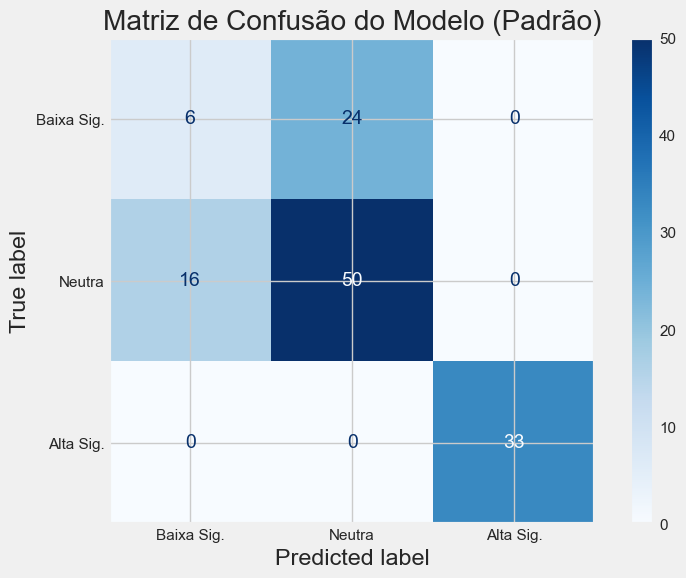


--- Análise com Threshold Customizado ---

--- Relatório com Threshold Customizado de 40% para 'Alta' ---
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        96
        True       1.00      1.00      1.00        33

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



In [ ]:
# A variável 'best_params' contém os melhores hiperparâmetros do Optuna.
# Os dataframes X_treino, y_treino, X_teste, y_teste já estão definidos.

print("--- Treinando e Avaliando o Modelo Final com Parâmetros Otimizados e Janela de Tempo de 3 Anos ---")

# 1. Instanciar o modelo final com os melhores parâmetros
final_params = best_params.copy()
final_params.update({
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'random_state': 42,
    'verbosity': -1
})
modelo_otimizado = lgb.LGBMClassifier(**final_params)


# ------------------------- AJUSTE CRÍTICO -------------------------
# 2. Filtrar o conjunto de treino para a janela de 3 anos
# <<< MUDANÇA PRINCIPAL AQUI >>>
print("\nFiltrando o conjunto de treino para a janela de 3 anos...")
ponto_de_corte_3a = X_treino.index.max() - pd.DateOffset(years=3)
X_treino_final = X_treino[X_treino.index >= ponto_de_corte_3a]
y_treino_final = y_treino.loc[X_treino_final.index]
print(f"Usando {len(X_treino_final)} amostras da janela de 3 anos para o treino final.")
# ------------------------------------------------------------------


# 3. Treinar o modelo no conjunto de treino OTIMIZADO (3 anos)
print("\nTreinando o modelo final no conjunto de treino otimizado...")
# Note que agora usamos os dataframes _final que foram filtrados
modelo_otimizado.fit(X_treino_final, y_treino_final)
print("Treinamento concluído.")


# 4. Fazer previsões (de classe e de probabilidade) no conjunto de TESTE
print("\nFazendo previsões no conjunto de teste...")
y_pred_otimizado = modelo_otimizado.predict(X_teste)
y_proba_otimizado = modelo_otimizado.predict_proba(X_teste)
print("Previsões concluídas.")


# 5. Avaliar a performance padrão (com threshold de 0.5)
print("\n--- Resultados Padrão no Conjunto de Teste ---")
print(classification_report(y_teste, y_pred_otimizado, labels=[-1, 0, 1], target_names=['Baixa Sig.', 'Neutra', 'Alta Sig.']))
final_auc = roc_auc_score(y_teste, y_proba_otimizado, multi_class='ovr', labels=[-1, 0, 1])
print(f"AUC ROC Final (One-vs-Rest): {final_auc:.4f}")

# Visualizar a Matriz de Confusão Padrão
cm = confusion_matrix(y_teste, y_pred_otimizado, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Baixa Sig.', 'Neutra', 'Alta Sig.'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Matriz de Confusão do Modelo (Padrão)")
plt.show()


# 6. Otimização e Análise do Ponto de Corte (Threshold Tuning)
print("\n--- Análise com Threshold Customizado ---")
df_probas = pd.DataFrame(y_proba_otimizado, columns=['proba_baixa', 'proba_neutra', 'proba_alta'], index=y_teste.index)
df_probas['real'] = y_teste
df_probas['pred_default'] = y_pred_otimizado

# Testando uma nova regra: Só prever 'Alta' se a probabilidade for > 40%
novo_threshold_alta = 0.40
df_probas['pred_custom_alta'] = np.where(df_probas['proba_alta'] > novo_threshold_alta, 1, 0) # Previsão binária: É alta ou não?

print(f"\n--- Relatório com Threshold Customizado de {novo_threshold_alta:.0%} para 'Alta' ---")
# Comparamos os dias que eram de fato de Alta (y_teste == 1) com nossas novas previsões customizadas
print(classification_report(
    (y_teste == 1), 
    (df_probas['pred_custom_alta'] == 1)
))